---
title: "PIC16B HW2:Web Scraping and visulization"
author: "Zhe Shen"
date: "2023-2-7"
categories: [PIC16B HW]

---

# PIC16B HW2:Web Scraping and visulization

# Introduce
In this blog, we will introduce the procedure of using **scrapy** for web scraping. Before that, we will briefly introduce the use of **fake user agent** to access web pages. This is because many webmasters believe that malicious web scraping can compromise the security of a web page's commercial information. However, we can use a **fake user agent** to circumvent the webmaster's access blocking. After we get the information that we need from the [TMDB](https://www.themoviedb.org/), we will use some simple **visualizations** to explore the question: 

`Which movies or TV shows have co-stars with your favorite movies or shows? `

You can access the git repository for this project via [this link](https://github.com/ZheShen00/pic16B-second-hw).

# 1.   Installation of scrapy framework and general setting

* You can complete the installation of scrapy by entering the following command in the terminal：
```pip install Scrapy```
* Create a new GitHub repository, and sync it with GitHub Desktop. Don't forget commit and push when you change your code.
* Then you can create create folder by enter the commands below in terminal:
```
conda activate PIC16B
scrapy startproject TMDB_scraper
cd TMDB_scraper
```
* Now we can start the programing of the scraping work. Once the programming is complete, we will name the code file as **tmdb_spider.py** and place it in the **spiders** folder.

# 2. Web Scraping Programing

## Part 1: Fake User Agent Setting

As I said before, many web pages disable access to web scraping for information security reasons, which can cause us to get a **403 error** and return an empty cvs file. To deal with this, I used the free services of the [ScrapeOps](https://scrapeops.io/) and the code reference to complete the setup of the fake user agent. The code is highly referenced from [this page](https://scrapeops.io/docs/fake-user-agent-headers-api/integrations/python-requests/).

In [2]:
import scrapy


import requests 
from random import randint

# I tried to get result.csv, I always got a empty csv file. 
# I do some search online and found it is a 403 Forbidden Error.
# The solution is need to requests fake user agent API, so I refer to the code of this website:
# https://scrapeops.io/docs/fake-user-agent-headers-api/integrations/python-requests/

def get_user_agent_list():
    API_KEY = '73c17bd8-df5e-4c16-9731-e27653449214' #Everyone has different API, so get your own on ScrapeOps
    response = requests.get('http://headers.scrapeops.io/v1/user-agents?api_key=' + API_KEY)
    json_response = response.json()
    return json_response.get('result', [])

def get_random_user_agent(user_agent_list):
    random_index = randint(0, len(user_agent_list) - 1)
    return user_agent_list[random_index]

# Retrieve User-Agent List From ScrapeOps
user_agent_list = get_user_agent_list()

## Add Random User-Agent To Headers
headers = {'User-Agent': get_random_user_agent(user_agent_list)}

The code works by configuring **scraper** so that it retrieves a batch of up-to-date user agents at startup, and then uses a random user agent for each request. This way we can avoid **403 errors**.

## Part 2: Start Scraping part
In this section, we will define a Class named **TmdbSpider**, which will be the main part of our web scraping.
* **name** is the spider's name.
* **start_urls** is the url of the web page we want access first.

In [ ]:
class TmdbSpider(scrapy.Spider):
    
    #define spider name
    name = 'tmdb_spider' 
    
    #the url that we would use scrapy on it.
    start_urls = ['https://www.themoviedb.org/movie/207703-kingsman-the-secret-service']


 In addition I create access to the web page through the new function **requests**. This function will start our request and add url and headers to object: **scrapy.Request**.

In [3]:
    def requests(self):
        '''
            Goals:
            1, Start our request
            2, Input the start url and add headers to object: scrapy.Request.
            3, Navigate to the page of the movie we want.
        '''
        for url in self.start_urls:
            yield scrapy.Request(url=url, headers=headers)

After completing the function definition in the previous step, we will be able to make a request via **requests**. Then we can start web scraping for the information we want to get. Here I will first try to get the list of all Crews and Cast. So we need to navigate to the **Full Crew & Cast** page. So I have defined function named **parse** below to accomplish these goals.

In [4]:
    def parse(self, response):
        '''
            Goals:
            1, Parse movie's page. 
            2, Find the full cast & crew link.
            3, Navigate to the full cast & crew page.
        '''
        
        # Find the Full Cast & Crew link and navigate that page.
        cast_page_link = response.css("p.new_button a::attr(href)").get()
        yield scrapy.Request(url = "https://www.themoviedb.org" + cast_page_link,
                            headers=headers,
                            callback=self.parse_full_credits)

**parse** works by finding the link suffix to the **full cast & crew** page and adding it to https://www.themoviedb.org to get the full link to the full cast & crew page. The location of the full cast & crew link can be found by right clicking on web page and choose inspect. Then we use **scrapy.Request** for scraping **full cast & crew**. It is worth mentioning that we have also added a parameter **callback** here to call the function named **parse_full_credits**. This will allow us to do further web scraping based on the information from the **full cast & crew** page.

In [ ]:
    def parse_full_credits(self, response):
        '''
            Goals:
            1, Parse the full cast & crew page.
            2, Find all actors' links.
            3, Navigate to the actors' pages respectively.
        '''

        # Find the link of all the actors.
        actors_links = response.css("ol[class='people credits '] p[class!='character'] a::attr(href)").getall()
        for actor_link in actors_links:  
            yield scrapy.Request(url = "https://www.themoviedb.org" + actor_link,
                                headers=headers,
                                callback=self.parse_actor_page)

About how **parse_full_credits** works, we first find the links to each actor's home page by **ol[class='people credits ']** and **p[class!='character']**. **a::attr(href)** will fetch the links and **.getall()** will scrape them. After all of the above, we again use the **callback** to help us with further web scraping. The next task will be done by **parse_actor_page**.

In [5]:
def parse_actor_page(self, response):
        '''
            Goals:
            1, Parse each actor page.
            2, Collete the actor name, and all movies' name which he/she has acted in.
            3, Output dictionaries containing the actor name and the movie name.
        '''

        # Collete actor name
        name = response.css("h2.title a::text").get()
        
        # Collete all movies' name which he/she has acted in.
        movies = response.css("table.credit_group a.tooltip bdi::text").getall()
        
        # Finalizes the work of parsing
        for movie in movies:
            yield{"actor name":name,
                  "movie name":movie}

**parse_actor_page** The main purpose is to get all the movies that all actors have been in. **h2.title a::text** will allow us to scrape the names of the actors. **table.credit_group a.tooltip bdi::text** will provide us with the names of all the movies the actor has been in. These can be obtained through the browser's check page. Finally we will build the dictionary based on the information obtained. Entering **scrapy crawl tmdb_spider -o result.csv** in the terminal will output the csv file.

# 3. visualizations

After we receive **result.cvs**, we can do some data analysis and visualization.Let's check the **result.csv** first.

In [36]:
import pandas as pd

# Check results.csv
data = pd.read_csv('results.csv')
data.head(21)

,actor name,movie name
0,Anne Wittman,Shapes
1,Anne Wittman,People in Landscape
2,Anne Wittman,The Mystery of D.B. Cooper
3,Anne Wittman,Avenue 5
4,Anne Wittman,Jesus Shows You the Way to the Highway
5,Anne Wittman,K-12
6,Anne Wittman,Fantastic Beasts and Where to Find Them
7,Anne Wittman,Jamie
8,Anne Wittman,Kingsman: The Secret Service
9,Anne Wittman,Pigeon


It looks great! That shows our work above are success.Now we need answer the question: `What movie or TV shows share actors with your favorite movie or show?`

For that, we will use **bar plot** to visualize the situation. It is worth noting that it is important to exclude movies that we perform web scraping in this process.

In [44]:
# Count the number of share actors
movie_count = pd.DataFrame(data['movie name'].value_counts())

# Reset the index of the DataFrame, and use the default one instead
movie_count = movie_count.reset_index()

# Rename the colum title
movie_count.columns = ['movie name','number of share actors']

# Show the top 10 movies
movie_count.head(11)

,movie name,number of share actors
0,Kingsman: The Secret Service,51
1,Kingsman: The Golden Circle,13
2,Kingsman: The Secret Service Revealed,11
3,Stardust,5
4,The Dark Crystal: Age of Resistance,4
5,Crossing Lines,4
6,The Graham Norton Show,4
7,Robin Hood,4
8,The Oscars,3
9,The Sandman,3


In this section, we read the CSV files and counted the number of shared actors. Without a doubt, **Kingsman: The Secret Service** is the number one ranked movie. This is because we did a web scrap based on the web page of this movie. Also, we can see that **Kingsman: The Golden Circle** and **Kingsman: The Secret Service Revealed** have the most shared actors. Since these 3 movies are part of the same series, it makes sense that they have a large number of shared actors. Next, I will visualize the top 10 movies using **bar plot**.

<AxesSubplot:xlabel='number of share actors', ylabel='movie name'>

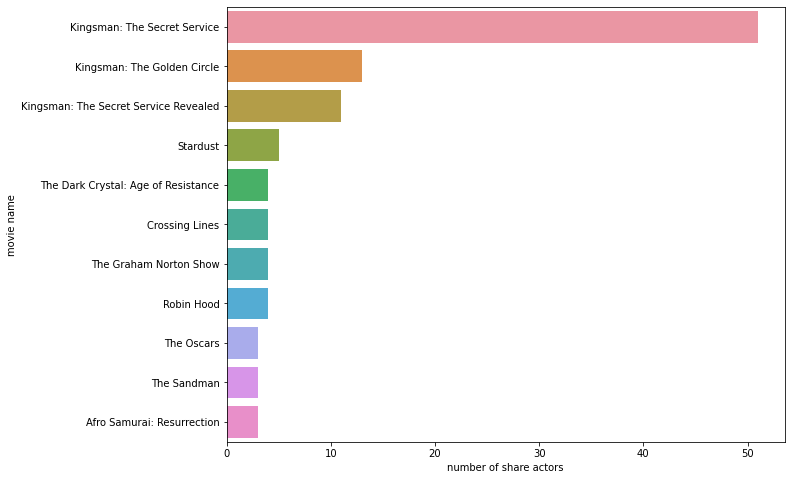

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

movies = movie_count.head(11)
plt.figure(figsize=(10, 8))
sns.barplot(y='movie name', x='number of share actors', data=movies)

As we can see, **Kingsman: The Secret Service**, **Kingsman: The Golden Circle** and **Kingsman: The Secret Service Revealed** are the movies with the most share actors. Except for these three movies, the number of share actors in other movies is relatively small. This is in line with our analysis above.